<a href="https://colab.research.google.com/github/pranshu-raj-211/project-alphazero/blob/main/Chapter7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.8 MB/s eta 0:00:00


In [ ]:
from tensorflow import keras
import numpy as np
import keras_tuner
import matplotlib.pyplot as plt

In [ ]:
vocabulary_size=10000
n_tags=10
n_departments=4

# creating inputs, specifying before is better, initializes model with some params without building specifically
title=keras.Input(shape=(vocabulary_size,),name='title')
body=keras.Input(shape=(vocabulary_size,),name='body')
tags=keras.Input(shape=(n_tags,),name='tags')

# concatenate multiple inputs into one layer (to be passed as one vector)
features=keras.layers.Concatenate()([title,body,tags])
features=keras.layers.Dense(units=64,activation='relu')(features)

# multi output, the magic happens here, both outputs can utilise the same network as they essentially work on same set of inputs
priority=keras.layers.Dense(units=1,activation='relu',name='Priority')(features)
departments=keras.layers.Dense(units=4,name='Department',activation='softmax')(features)

model=keras.Model(inputs=[title,body,tags],outputs=[priority,departments])

In [ ]:
model.weights
# random weights that model has been init with, won't be created if we don't specify input shape(either before or after)

[<tf.Variable 'dense/kernel:0' shape=(20010, 64) dtype=float32, numpy=
 array([[ 0.0124368 ,  0.00459161, -0.01066653, ...,  0.00328981,
         -0.00962793,  0.01001624],
        [-0.01670271,  0.00037037,  0.00549824, ..., -0.0056449 ,
         -0.00482731,  0.00980308],
        [-0.00954118,  0.01317134,  0.00412477, ...,  0.00131599,
          0.00291693, -0.01465539],
        ...,
        [-0.00110229,  0.00456338,  0.01425062, ..., -0.00190245,
         -0.00197508, -0.01482349],
        [-0.00209623,  0.01669556, -0.0086483 , ...,  0.01329243,
         -0.01214483, -0.00696767],
        [-0.00048195,  0.01550207,  0.00607631, ...,  0.00427085,
          0.00552497, -0.01585748]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(64,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

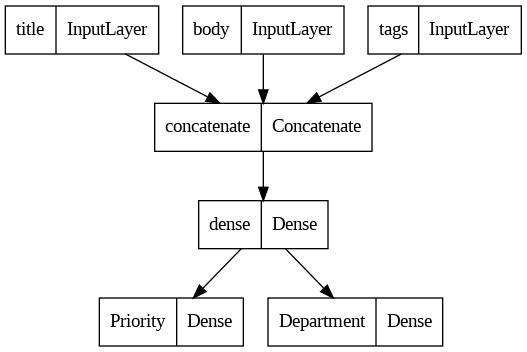

In [ ]:
keras.utils.plot_model(model,'ticket_classifier.png')
# creates a DAG of my model, essentially what the keras functional api does

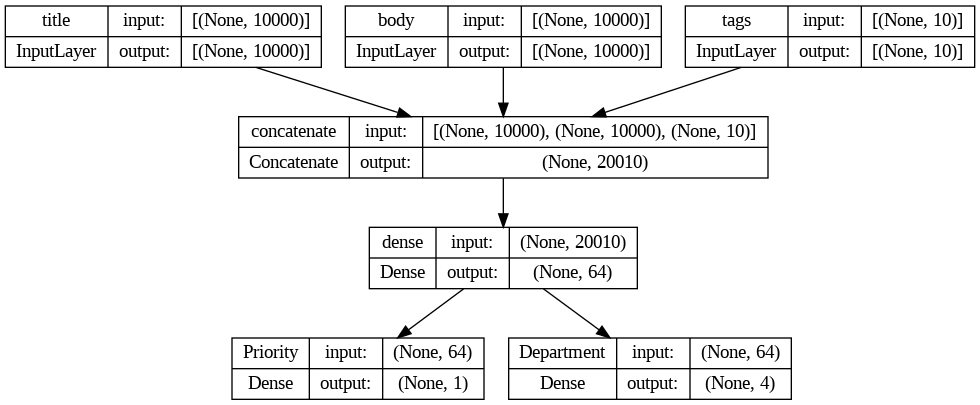

In [ ]:
keras.utils.plot_model(model,'ticket_classifier.png', show_shapes=True)
#use for debugging

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 title (InputLayer)          [(None, 10000)]              0         []                            
                                                                                                  
 body (InputLayer)           [(None, 10000)]              0         []                            
                                                                                                  
 tags (InputLayer)           [(None, 10)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 20010)                0         ['title[0][0]',               
                                                                     'body[0][0]',            

### I'm using dummy data for demonstration purposes, will generate or fetch some coherent data later.

In [ ]:
n_samples=1600
title_data=np.random.randint(0,2,size=(n_samples,vocabulary_size))
body_data=np.random.randint(0,2,size=(n_samples,vocabulary_size))
tags_data=np.random.randint(0,2,size=(n_samples,n_tags))

priority_data=np.random.random(size=(n_samples,1))
department_data=np.random.randint(0,2,size=(n_samples,4))


In [ ]:
model.compile(optimizer='rmsprop',loss=['mean_squared_error','categorical_crossentropy'],
              metrics=[['mean_absolute_error'],['accuracy']])

model.fit([title_data,body_data,tags_data],[priority_data,department_data],
          epochs=2)

priortiy_preds,department_preds=model.predict([title_data,body_data,tags_data])

Epoch 1/2
50/50 [==============================] - 3s 28ms/step - loss: 35.5553 - Priority_loss: 0.3291 - Department_loss: 35.2261 - Priority_mean_absolute_error: 0.4962 - Department_accuracy: 0.3025
Epoch 2/2
50/50 [==============================] - 1s 10ms/step


This way of passing inputs is often a cause of error, therefore to mitigate the issues brought about by this it is better to pass features and targets as dictionaries

In [ ]:
model.compile(optimizer='rmsprop',
              loss={'Priority':'mean_squared_error','Department':'categorical_crossentropy'},
              metrics={'Priority':['mean_absolute_error'],'Department':['accuracy']})

model.fit({'title':title_data,'body':body_data,'tags':tags_data},
          {'Priority':priority_data,'Department':department_data},
          epochs=1)

model.evaluate({'title':title_data,'body':body_data,'tags':tags_data},
          {'Priority':priority_data,'Department':department_data})

priority_preds,department_preds=model.predict({'title':title_data,'body':body_data,'tags':tags_data})

50/50 [==============================] - 0s 8ms/step


### Reusing previous layers

This to me is the most useful feature of the functional API, it allows adding other layers to an intermediate layer of the neural network without affecting the rest of the parts.

Conceptually this might be similar to transfer learning, adding a few layers to a pretrained model to improve generalisation for a specific task.

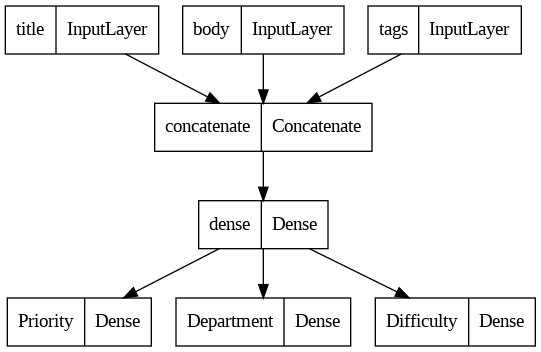

In [ ]:
features=model.layers[4].output
difficulty=keras.layers.Dense(3,activation='softmax',name='Difficulty')(features)

model_1=keras.Model(inputs=[title,body,tags],
                    outputs=[priority,departments,difficulty])

keras.utils.plot_model(model_1,'ticket_classifier_updated.png')

I'm not doing model subclassing right now as it is quite similar to the Pytorch way of writing code, which I'm familiar with.

However, there is something that piques my interest - making my own metrics and loss functions. I'll implement a few of these here.

In [ ]:
from keras import backend as K

def l1_loss(y_true,y_pred):
    error=y_true-y_pred
    return np.abs(error)

def l2_loss(y_true,y_pred):
    squared_error=np.square(y_true-y_pred)
    return np.sqrt(squared_error)

# but using numpy based functions may not be good, as we don't know if it will be imported
# however this can still be used for evaluation after training
# best approach is to use keras backend

def mae(y_true,y_pred):
    error=y_true-y_pred
    return K.sum(K.abs(error))

def rmse(y_true,y_pred):
    squared_error=K.square(y_true-y_pred)
    return K.sum(K.sqrt(squared_error))

def precision(y_true,y_pred):
    true_positives=K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives=K.sum(K.round(K.clip(y_pred, 0, 1)))
    pass

def recall(y_true,y_pred):
    pass

In [ ]:
# prompt: write a custom loss function in keras for precision and recall

def precision(y_true,y_pred):
    true_positives=K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives=K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives/total_positives

def recall(y_true,y_pred):
    true_positives=K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives=K.sum(y_true)
    return true_positives/total_positives

def f1_score(y_true,y_pred):
    precision_score=precision(y_true,y_pred)
    recall_score=recall(y_true,y_pred)
    return 2*precision_score*recall_score/(precision_score+recall_score)

def custom_loss(y_true,y_pred):
    return -f1_score(y_true,y_pred)
